In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision #이미지 데이터셋과 전처리 모듈
import torch.nn as nn #nn이 실제 레이어 모듈
import torch.optim as optim #optimizer 모듈
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets#데이터셋, transforms #전처리모듈

In [ ]:
#gpu가 적용되는지 확인하는 코드 cuda == gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
label = train_dataset.classes

100%|██████████| 170M/170M [00:04<00:00, 35.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
image, label = next(iter(train_dataloader))

In [ ]:
def image_show(img):
    plt.figure(figsize=(8, 8))
    for i in range(img.shape[0]):
        image = img[i].numpy().transpose(1, 2, 0)#transpose(w, h, ch) --> w, h, ch의 인덱스값이 매개변수로 들어감 #numpy로 변환해줘야 transpose가 먹는다.
        plt.subplot(4, 4, i + 1)# 행, 열, 사진번호
        plt.imshow(image)
    plt.show()

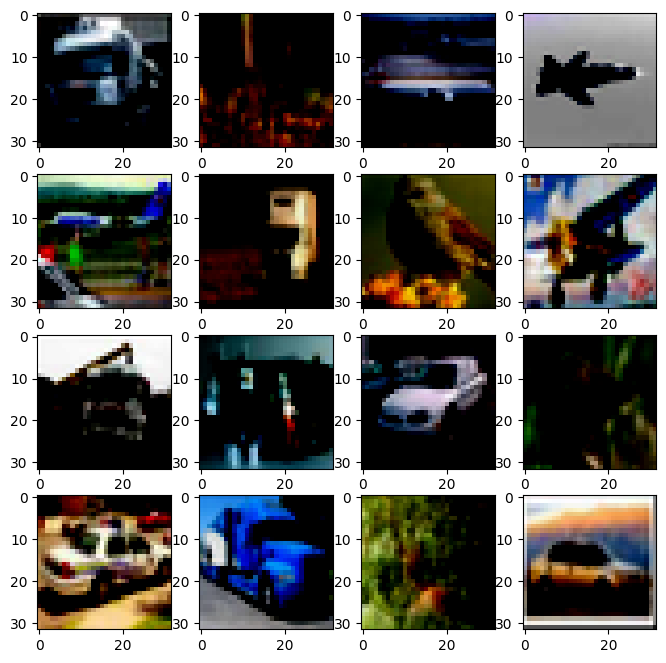

In [ ]:
image_show(image)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # self.layer5 = nn.Sequential(
        #     nn.Conv2d(128, 256, 3, padding=1),#8*8
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(2,2)#4*4
        # )
        self.fc1 = nn.Sequential(
            # nn.Dropout(0.5),
            nn.Linear(128*6*6, 4608, bias=True),
            nn.ReLU(inplace=True)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4608, 4608, bias=True),
            nn.ReLU(inplace=True)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(4608, 10, bias=True),
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = self.layer5(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [ ]:
model = Model().to(device) #객체로 만듬

loss_fn = nn.CrossEntropyLoss() #loss (mse, crossentropyloss 공부 필요)
optimizer = optim.Adam(model.parameters(), lr=1e-3)#optimizer(가중치값, learning rate -> 경사하강법의 보폭 1e - 3(1*e^(-3)) 이 default값이다.)
#learning rate의 설정값은 최소값을 설정한다.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader) # 사실 없어도 됨 마지막에 가독성을 좋게하기위해 사용
    model.train()#torch안의 module안에 train이라는 메소드가 있다.

    for batch, data in enumerate(dataloader):
        image, label = data
        #gpu
        image, label = image.to(device), label.to(device)

        # Compute prediction error
        pred = model(image).to(device) #model.forward(image)
        # softmax = nn.Softmax(dim=1)
        # pred_probab = softmax(pred)
        loss = loss_fn(pred, label)
        # backpropagation
        loss.backward() # 쓸모없는 노드를 지운다. #매개변수를 안정해주면 랜덤으로 잡고 경사하강을 한다.
        optimizer.step() #learning rate 만큼 내려간다.
        optimizer.zero_grad() #초기화해주는데 해주는 이유는 이전 스텝을 기억하고있으면 다음 스텝에 영향을 줄 수 있기때문에 초기화한다.

        if not(batch % 100):
            loss, current = loss.item(), (batch + 1) * len(image)
            print(f"loss : {loss:>7f}   [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #평가를 해주겠다 명시
    test_loss, correct = 0, 0

    with torch.no_grad(): #no_grad -> 최적화를 수행하지 않겠다.
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image).to(device)
            # softmax = nn.Softmax(dim=1)
            # pred_probab = softmax(pred)
            test_loss += loss_fn(pred, label).item() #.item() -> loss_fn에 있는 데이터값을 불러준다.
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()
                            #argmax --> 예측값중에 가장 큰 값을 뽑아오는 것

    test_loss /= num_batches
    correct /=size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 50
for i in range(epochs):
    print(f"Epoch {i + 1}\n------------------------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done")

Epoch 1
------------------------------------------------
loss : 2.304123   [   16/ 3125]
loss : 2.026450   [ 1616/ 3125]
loss : 1.869441   [ 3216/ 3125]
loss : 1.871101   [ 4816/ 3125]
loss : 2.021852   [ 6416/ 3125]
loss : 1.789016   [ 8016/ 3125]
loss : 1.584066   [ 9616/ 3125]
loss : 1.325600   [11216/ 3125]
loss : 1.711667   [12816/ 3125]
loss : 1.979450   [14416/ 3125]
loss : 1.977732   [16016/ 3125]
loss : 1.187027   [17616/ 3125]
loss : 1.923944   [19216/ 3125]
loss : 1.738098   [20816/ 3125]
loss : 1.438021   [22416/ 3125]
loss : 1.409033   [24016/ 3125]
loss : 1.289563   [25616/ 3125]
loss : 1.191463   [27216/ 3125]
loss : 1.245020   [28816/ 3125]
loss : 1.401547   [30416/ 3125]
loss : 1.564259   [32016/ 3125]
loss : 0.980993   [33616/ 3125]
loss : 1.853861   [35216/ 3125]
loss : 1.300946   [36816/ 3125]
loss : 1.395741   [38416/ 3125]
loss : 1.122175   [40016/ 3125]
loss : 1.471783   [41616/ 3125]
loss : 1.084831   [43216/ 3125]
loss : 1.262765   [44816/ 3125]
loss : 1.180380